In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torchvision.transforms.functional import to_tensor
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Task 1

In [38]:
# Get the mean, std of the pixel intensity values
def get_mean_and_std():
  # Get unnormalized data with pixel values [0,1]
  dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
  )

  # Split into 60_000/1_000 = 60 batches for faster processing
  loader = DataLoader(dataset, batch_size=1000, shuffle=False)
  mean, std, num_batches = 0.0, 0.0, 0

  for images, _ in loader:
    batch_samples = images.size(0)

    # Convert 28x28 arrray to 784x1
    images = images.view(batch_samples, -1)

    # Get mean and std for pixel values of the batch
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    num_batches += batch_samples

  mean /= num_batches
  std /= num_batches

  return mean.item(), std.item()

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using the device: ", device)

Using the device:  cuda


In [40]:
# Get the train and test datasets loaders
def get_datasets(is_cnn = False, is_Resnet = False, augment_data = True, use_gpu = False):
  # Get the normalization mean and std
  mean, std = get_mean_and_std()
  batch_size = 256

  transforms_list_train = []
  transforms_list_test = []

  if is_Resnet:
    print("Getting datasets for ResNet model")
    transforms_list_train = [
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]

    transforms_list_test = [
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]

  elif is_cnn:
    transforms_list_test = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
    ]

    transforms_list_train = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
    ]

    if augment_data:
      print("Getting datasets for CNN with data augmentation")
      transforms_list_train = [
        transforms.RandomRotation(10),
        transforms.RandomAffine(
          degrees=0,
          translate=(0.1, 0.1),
          scale=(0.95, 1.05)
        ),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
      ] + transforms_list_train
    else:
      print("Getting datasets for CNN without data augmentation")
  else:
    transforms_list_test = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std),
      transforms.Lambda(lambda x: x.view(-1))
    ]

    transforms_list_train = [
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std),
      transforms.Lambda(lambda x: x.view(-1))
    ]

    if augment_data:
      print("Getting datasets for NN with data augmentation")
      transforms_list_train = [
        transforms.RandomRotation(10),
        transforms.RandomAffine(
          degrees=0,
          translate=(0.1, 0.1),
          scale=(0.95, 1.05)
        ),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
      ] + transforms_list_train
    else:
      print("Getting datasets for NN without data augmentation")

  data_transform_train = transforms.Compose(transforms_list_train)
  data_transform_test = transforms.Compose(transforms_list_test)

  # Get the transformed train and test datset
  complete_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transform_train)
  complete_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transform_test)

  train_loader = DataLoader(complete_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  test_loader = DataLoader(complete_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  return train_loader, test_loader

In [41]:
# View the first 10 test and training datasets items
def visualize_datasets():
  # Get data
  training_data, testing_data = get_datasets(is_cnn=True, augment_data=False)

  train_images, train_labels = next(iter(training_data))
  test_images, test_labels = next(iter(testing_data))

  print("\n\nClassication topology: ")
  print("0 - T-shirt/top")
  print("1 - Trouser")
  print("2 - Pullover")
  print("3 - Dress")
  print("4 - Coat")
  print("5 - Sandal")
  print("6 - Shirt")
  print("7 - Sneaker")
  print("8 - Bag")
  print("9 - Ankle boot\n\n")

  # Print the dimensions of the data
  print(f"Training images shape: {train_images.shape}")
  print(f"Training labels shape: {train_labels.shape}")
  print(f"First 10 training labels: {train_labels[0:10]}")

  plt.figure(figsize=(12, 4))

  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_images[i, 0, :, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Train: {train_labels[i].item()}")

    plt.subplot(2, 10, i + 11)
    plt.imshow(test_images[i, 0, :, :], cmap='gray')
    plt.title(f"Test: {test_labels[i].item()}")
    plt.axis('off')
  plt.show()

Getting datasets for CNN without data augmentation


Classication topology: 
0 - T-shirt/top
1 - Trouser
2 - Pullover
3 - Dress
4 - Coat
5 - Sandal
6 - Shirt
7 - Sneaker
8 - Bag
9 - Ankle boot


Training images shape: torch.Size([256, 1, 28, 28])
Training labels shape: torch.Size([256])
First 10 training labels: tensor([7, 5, 0, 4, 9, 0, 6, 5, 4, 1])


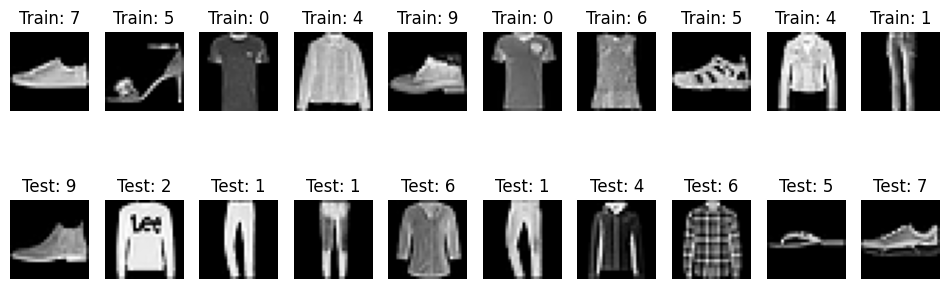

In [42]:
visualize_datasets()

# Task 3

We are running the tasks 3.6, 3.7 and 3.8

## CNN Model


In [43]:
def calculate_image_size(image_size, kernel_size, stride, padding):
  return int((image_size - kernel_size + 2 * padding) / stride + 1)

In [44]:
class CNN(nn.Module):
  def __init__(self, *params):
    super().__init__()

    nn_size, conv1, conv2, max_pool, fc1, fc2, dropout = params

    self.nn_size = nn_size

    self.conv1 = conv1
    self.conv2 = conv2
    self.max_pool = max_pool

    self.fc1 = fc1
    self.fc2 = fc2

    self.dropout = dropout

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = x.view(-1, self.nn_size)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [45]:
def train_model(model, train_loader, test_loader, epochs, learning_rate):
  start_time = time.time()
  model.to(device)

  optimizer = Adam(model.parameters(), lr=learning_rate)
  loss = nn.CrossEntropyLoss()

  train_losses = []
  test_losses = []
  train_accuracy = []
  test_accuracy = []

  for epoch in range(epochs):
    model.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in tqdm.tqdm(train_loader):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      y_hat = torch.argmax(outputs, dim=1)
      loss_value = loss(outputs, labels)

      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()

      total_loss += loss_value.item()
      correct_predictions += (y_hat == labels).sum().item()
      total_predictions += len(y_hat)

    test_losses_iteration, test_accuracy_iteration = test_model(model, test_loader, show_heatmap=False)
    test_losses.append(test_losses_iteration)
    test_accuracy.append(test_accuracy_iteration)

    train_losses.append(total_loss / len(train_loader))
    train_score = correct_predictions / total_predictions
    train_accuracy.append(train_score)

    print(f"\nEpoch {epoch + 1}, Train Loss: {(total_loss / len(train_loader)):.2f}, Train accuracy: {train_score:.2%}, Test accuracy: {test_accuracy_iteration:.2%}, Test loss: {test_losses_iteration[0]:.2f}\n\n")

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")

  plt.figure(figsize=(12, 4))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(test_losses, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(range(1,epochs, 1))
  plt.title("Losses vs Epoch")
  plt.legend()
  plt.show()

  plt.figure(figsize=(12, 4))
  plt.plot(train_accuracy, label='Train Accuracy')
  plt.plot(test_accuracy, label='Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.xticks(range(1,epochs, 1))
  plt.title("Accuracy vs Epoch")
  plt.legend()
  plt.show()

  test_model(model, test_loader, show_heatmap=True)

  return model

In [46]:
def test_model(model, test_loader, show_heatmap=False):
  model.eval()
  loss = nn.CrossEntropyLoss()

  predictions_made = []
  true_labels = []

  test_losses = []
  train_losses = []

  correct = 0
  total = 0
  total_loss = 0

  with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      preds = torch.argmax(outputs, dim=1)

      loss_value = loss(outputs, labels)
      total_loss += loss_value.item()

      predictions_made.extend(preds.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

      correct += (preds == labels).sum().item()
      total += labels.size(0)

  test_losses.append(total_loss / len(test_loader))
  test_accuracy = correct / total

  if show_heatmap:
    c_matrix = confusion_matrix(true_labels, predictions_made)
    plt.figure(figsize=(5, 4))
    sns.heatmap(c_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=datasets.MNIST.classes, yticklabels=datasets.MNIST.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

  return test_losses, test_accuracy

## Setting up the different test cases

In [47]:
def get_params_1():
  in_channels_1 = 1
  out_channels_1 = 32
  in_channels_2 = out_channels_1
  out_channels_2 = 64

  k_1 = 2
  s_1 = 1
  p_1 = 0

  k_2 = 2
  s_2 = 1
  p_2 = 0

  pool_k = 2
  pool_s = 1
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [48]:
def get_params_2():
  in_channels_1 = 1
  out_channels_1 = 16
  in_channels_2 = out_channels_1
  out_channels_2 = 32

  k_1 = 3
  s_1 = 1
  p_1 = 1

  k_2 = 3
  s_2 = 1
  p_2 = 1

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [49]:
def get_params_3():
  in_channels_1 = 1
  out_channels_1 = 32
  in_channels_2 = out_channels_1
  out_channels_2 = 64

  k_1 = 3
  s_1 = 1
  p_1 = 1

  k_2 = 3
  s_2 = 1
  p_2 = 1

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [50]:
def get_params_4():
  in_channels_1 = 1
  out_channels_1 = 16
  in_channels_2 = out_channels_1
  out_channels_2 = 32

  k_1 = 5
  s_1 = 1
  p_1 = 2

  k_2 = 5
  s_2 = 1
  p_2 = 2

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

In [51]:
def get_params_5():
  in_channels_1 = 1
  out_channels_1 = 32
  in_channels_2 = out_channels_1
  out_channels_2 = 64

  k_1 = 5
  s_1 = 1
  p_1 = 2

  k_2 = 5
  s_2 = 1
  p_2 = 2

  pool_k = 2
  pool_s = 2
  pool_p = 0

  image_size_original = 28
  image_size_1 = calculate_image_size(image_size_original, k_1, s_1, p_1)
  image_size_2 = calculate_image_size(image_size_1, pool_k, pool_s, pool_p)
  image_size_3 = calculate_image_size(image_size_2, k_2, s_2, p_2)
  image_size_4 = calculate_image_size(image_size_3, pool_k, pool_s, pool_p)
  image_size = image_size_4 * image_size_4

  in_features_nn_1 = out_channels_2 * image_size
  out_features_nn_1 = 256
  in_features_nn_2 = out_features_nn_1
  out_features_nn_2 = 10

  nn_size = in_features_nn_1

  conv1 = nn.Conv2d(in_channels=in_channels_1,
                         out_channels=out_channels_1,
                         kernel_size=k_1,
                         stride=s_1,
                         padding=p_1)
  conv2 = nn.Conv2d(in_channels=in_channels_2,
                         out_channels=out_channels_2,
                         kernel_size=k_2,
                         stride=s_2,
                         padding=p_2)
  max_pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s, padding=pool_p)

  fc1 = nn.Linear(in_features=in_features_nn_1, out_features=out_features_nn_1)
  fc2 = nn.Linear(in_features=in_features_nn_2, out_features=out_features_nn_2)

  dropout = nn.Dropout(0.25)

  return nn_size, conv1, conv2, max_pool, fc1, fc2, dropout

## Training on non-augmented data

In [52]:
learning_rate = 0.001
epochs = 10
train_loader, test_loader = get_datasets(is_cnn=True, augment_data=False)

Getting datasets for CNN without data augmentation


100%|██████████| 40/40 [00:01<00:00, 23.91it/s]



Epoch 1, Train Loss: 0.48, Train accuracy: 83.11%, Test accuracy: 88.23%, Test loss: 0.32




100%|██████████| 40/40 [00:01<00:00, 23.79it/s]



Epoch 2, Train Loss: 0.28, Train accuracy: 89.94%, Test accuracy: 90.41%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 22.65it/s]



Epoch 3, Train Loss: 0.23, Train accuracy: 91.43%, Test accuracy: 89.85%, Test loss: 0.27




100%|██████████| 40/40 [00:02<00:00, 19.64it/s]



Epoch 4, Train Loss: 0.20, Train accuracy: 92.57%, Test accuracy: 91.33%, Test loss: 0.23




100%|██████████| 40/40 [00:02<00:00, 16.82it/s]



Epoch 5, Train Loss: 0.17, Train accuracy: 93.64%, Test accuracy: 91.55%, Test loss: 0.24




100%|██████████| 40/40 [00:02<00:00, 15.26it/s]



Epoch 6, Train Loss: 0.15, Train accuracy: 94.58%, Test accuracy: 91.84%, Test loss: 0.24




100%|██████████| 40/40 [00:02<00:00, 17.70it/s]



Epoch 7, Train Loss: 0.13, Train accuracy: 95.36%, Test accuracy: 92.29%, Test loss: 0.23




100%|██████████| 40/40 [00:02<00:00, 18.26it/s]



Epoch 8, Train Loss: 0.11, Train accuracy: 96.08%, Test accuracy: 91.85%, Test loss: 0.25




100%|██████████| 40/40 [00:02<00:00, 19.67it/s]



Epoch 9, Train Loss: 0.09, Train accuracy: 96.62%, Test accuracy: 92.56%, Test loss: 0.25




100%|██████████| 40/40 [00:01<00:00, 20.50it/s]



Epoch 10, Train Loss: 0.08, Train accuracy: 96.95%, Test accuracy: 92.22%, Test loss: 0.26


Training time: 131.85 seconds


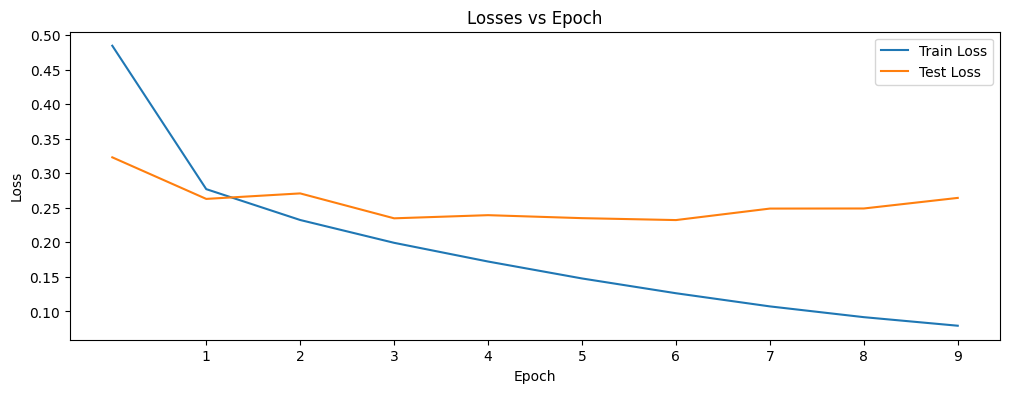

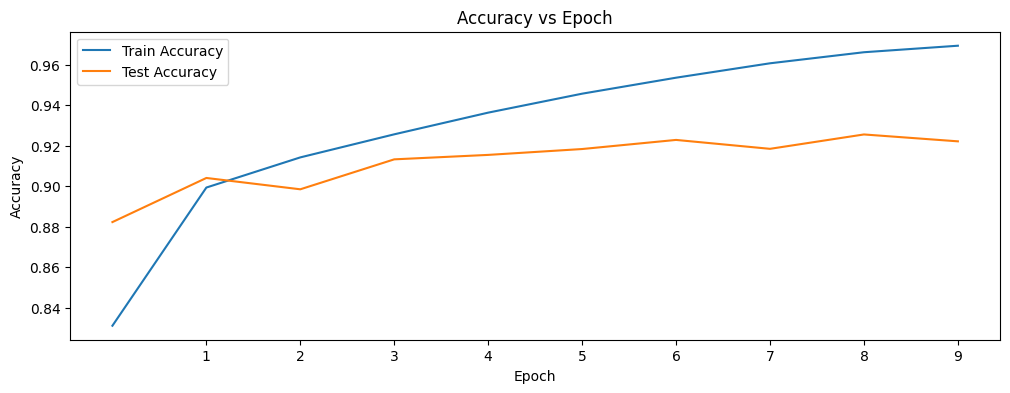

100%|██████████| 40/40 [00:01<00:00, 23.01it/s]


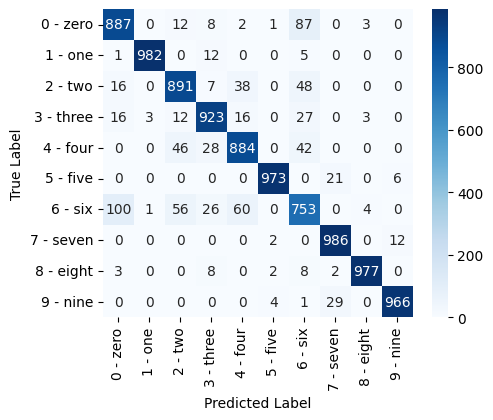

In [53]:
params_1 = get_params_1()
untrained_model = CNN(*params_1)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:01<00:00, 24.59it/s]



Epoch 1, Train Loss: 0.57, Train accuracy: 79.65%, Test accuracy: 85.52%, Test loss: 0.39




100%|██████████| 40/40 [00:01<00:00, 23.85it/s]



Epoch 2, Train Loss: 0.35, Train accuracy: 87.56%, Test accuracy: 87.85%, Test loss: 0.33




100%|██████████| 40/40 [00:01<00:00, 23.21it/s]



Epoch 3, Train Loss: 0.30, Train accuracy: 89.14%, Test accuracy: 87.80%, Test loss: 0.33




100%|██████████| 40/40 [00:01<00:00, 24.70it/s]



Epoch 4, Train Loss: 0.27, Train accuracy: 90.12%, Test accuracy: 89.75%, Test loss: 0.28




100%|██████████| 40/40 [00:01<00:00, 23.24it/s]



Epoch 5, Train Loss: 0.25, Train accuracy: 90.77%, Test accuracy: 90.60%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 24.24it/s]



Epoch 6, Train Loss: 0.24, Train accuracy: 91.30%, Test accuracy: 90.26%, Test loss: 0.27




100%|██████████| 40/40 [00:01<00:00, 24.10it/s]



Epoch 7, Train Loss: 0.22, Train accuracy: 91.87%, Test accuracy: 90.53%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 24.13it/s]



Epoch 8, Train Loss: 0.21, Train accuracy: 92.26%, Test accuracy: 90.97%, Test loss: 0.25




100%|██████████| 40/40 [00:01<00:00, 24.42it/s]



Epoch 9, Train Loss: 0.20, Train accuracy: 92.63%, Test accuracy: 91.42%, Test loss: 0.23




100%|██████████| 40/40 [00:01<00:00, 24.21it/s]



Epoch 10, Train Loss: 0.18, Train accuracy: 93.12%, Test accuracy: 91.53%, Test loss: 0.24


Training time: 125.87 seconds


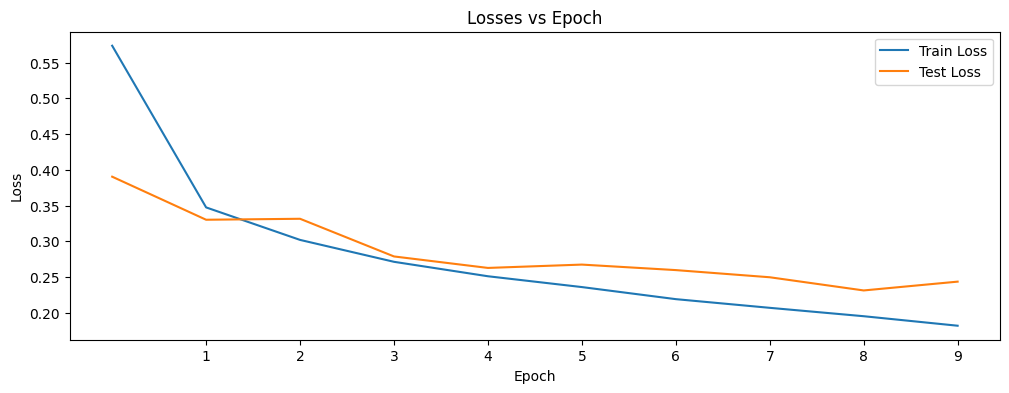

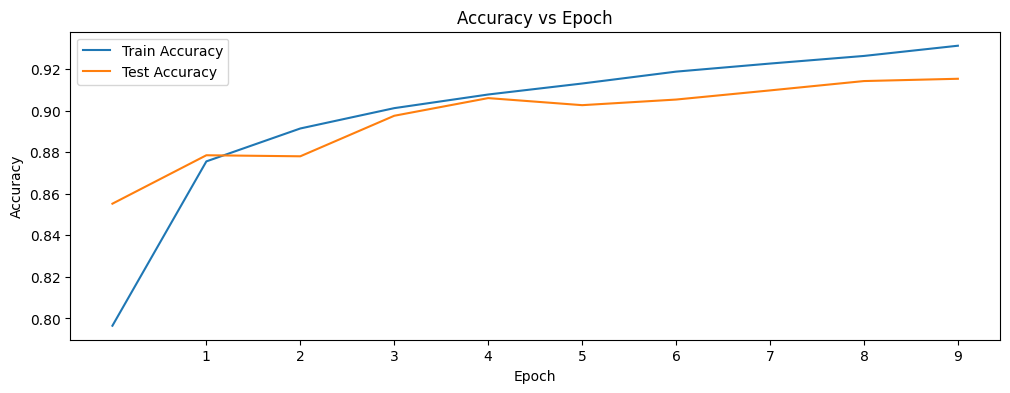

100%|██████████| 40/40 [00:01<00:00, 23.82it/s]


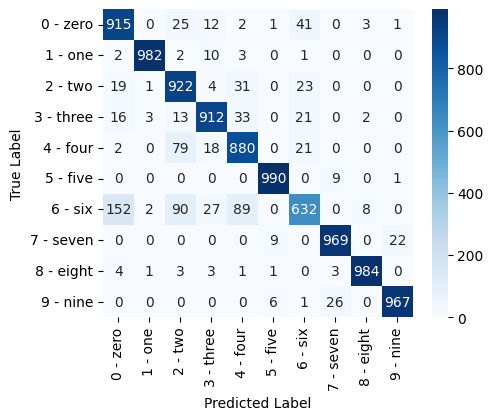

In [54]:
params_2 = get_params_2()
untrained_model = CNN(*params_2)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:01<00:00, 24.03it/s]



Epoch 1, Train Loss: 0.51, Train accuracy: 81.53%, Test accuracy: 87.29%, Test loss: 0.35




100%|██████████| 40/40 [00:01<00:00, 24.12it/s]



Epoch 2, Train Loss: 0.32, Train accuracy: 88.42%, Test accuracy: 89.31%, Test loss: 0.29




100%|██████████| 40/40 [00:01<00:00, 23.76it/s]



Epoch 3, Train Loss: 0.28, Train accuracy: 89.84%, Test accuracy: 90.34%, Test loss: 0.27




100%|██████████| 40/40 [00:01<00:00, 23.87it/s]



Epoch 4, Train Loss: 0.24, Train accuracy: 91.02%, Test accuracy: 90.57%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 24.13it/s]



Epoch 5, Train Loss: 0.22, Train accuracy: 91.95%, Test accuracy: 91.04%, Test loss: 0.24




100%|██████████| 40/40 [00:01<00:00, 24.03it/s]



Epoch 6, Train Loss: 0.20, Train accuracy: 92.62%, Test accuracy: 91.35%, Test loss: 0.23




100%|██████████| 40/40 [00:01<00:00, 24.15it/s]



Epoch 7, Train Loss: 0.18, Train accuracy: 93.31%, Test accuracy: 91.70%, Test loss: 0.23




100%|██████████| 40/40 [00:01<00:00, 23.71it/s]



Epoch 8, Train Loss: 0.17, Train accuracy: 93.80%, Test accuracy: 92.47%, Test loss: 0.22




100%|██████████| 40/40 [00:01<00:00, 24.79it/s]



Epoch 9, Train Loss: 0.15, Train accuracy: 94.36%, Test accuracy: 91.98%, Test loss: 0.23




100%|██████████| 40/40 [00:01<00:00, 24.54it/s]



Epoch 10, Train Loss: 0.14, Train accuracy: 94.90%, Test accuracy: 91.98%, Test loss: 0.23


Training time: 131.37 seconds


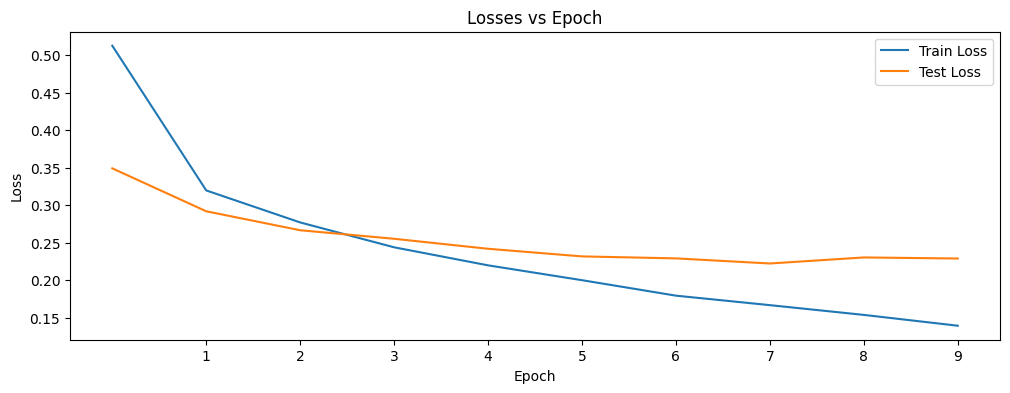

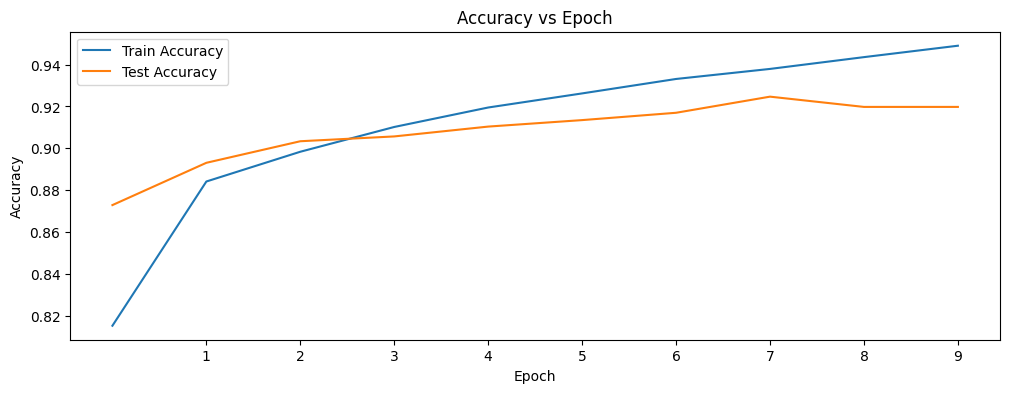

100%|██████████| 40/40 [00:01<00:00, 23.71it/s]


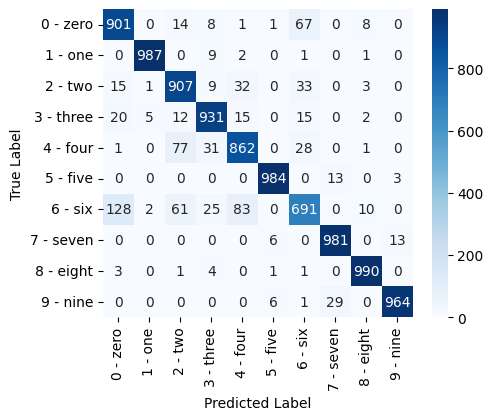

In [55]:
params_3 = get_params_3()
untrained_model = CNN(*params_3)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:01<00:00, 22.97it/s]



Epoch 1, Train Loss: 0.57, Train accuracy: 79.62%, Test accuracy: 86.18%, Test loss: 0.38




100%|██████████| 40/40 [00:01<00:00, 23.13it/s]



Epoch 2, Train Loss: 0.35, Train accuracy: 87.44%, Test accuracy: 88.21%, Test loss: 0.32




100%|██████████| 40/40 [00:01<00:00, 24.03it/s]



Epoch 3, Train Loss: 0.29, Train accuracy: 89.35%, Test accuracy: 89.56%, Test loss: 0.29




100%|██████████| 40/40 [00:01<00:00, 24.74it/s]



Epoch 4, Train Loss: 0.26, Train accuracy: 90.40%, Test accuracy: 90.20%, Test loss: 0.27




100%|██████████| 40/40 [00:01<00:00, 24.31it/s]



Epoch 5, Train Loss: 0.23, Train accuracy: 91.44%, Test accuracy: 90.72%, Test loss: 0.25




100%|██████████| 40/40 [00:01<00:00, 24.04it/s]



Epoch 6, Train Loss: 0.22, Train accuracy: 91.97%, Test accuracy: 90.73%, Test loss: 0.25




100%|██████████| 40/40 [00:01<00:00, 23.72it/s]



Epoch 7, Train Loss: 0.20, Train accuracy: 92.57%, Test accuracy: 91.04%, Test loss: 0.25




100%|██████████| 40/40 [00:01<00:00, 24.16it/s]



Epoch 8, Train Loss: 0.18, Train accuracy: 93.25%, Test accuracy: 90.56%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 22.73it/s]



Epoch 9, Train Loss: 0.17, Train accuracy: 93.60%, Test accuracy: 91.42%, Test loss: 0.24




100%|██████████| 40/40 [00:01<00:00, 23.89it/s]



Epoch 10, Train Loss: 0.16, Train accuracy: 94.11%, Test accuracy: 90.83%, Test loss: 0.25


Training time: 125.25 seconds


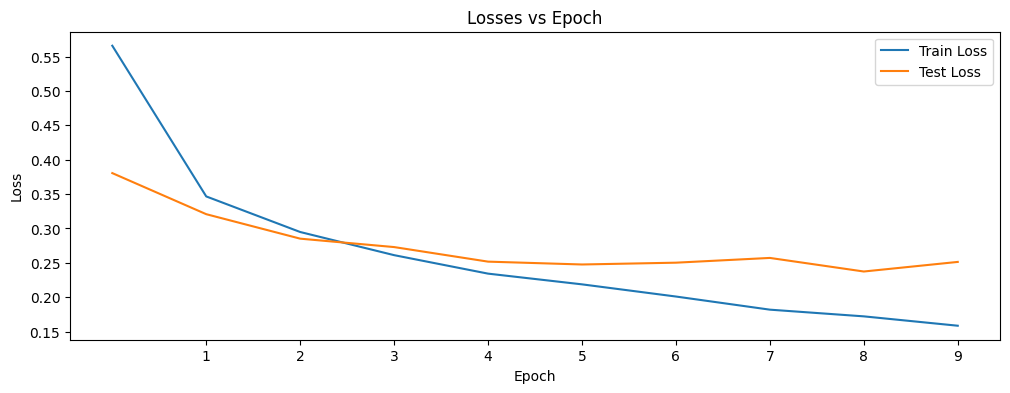

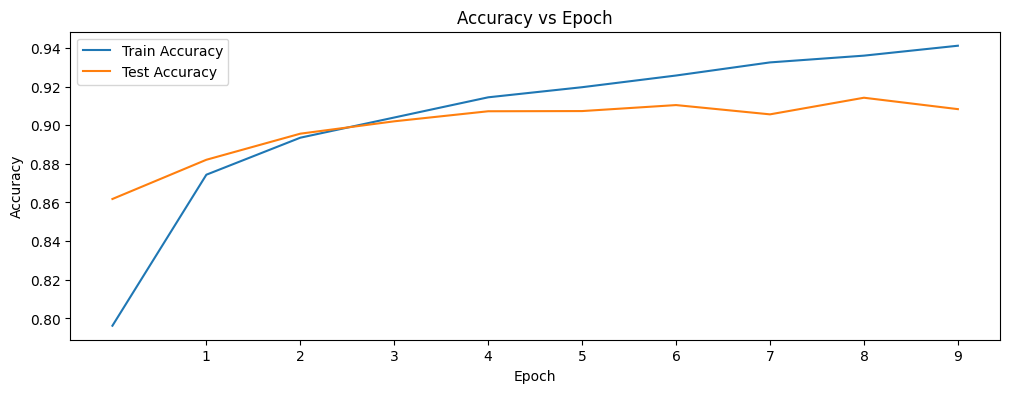

100%|██████████| 40/40 [00:01<00:00, 20.88it/s]


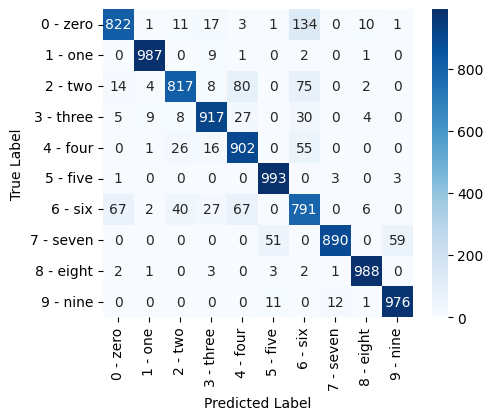

In [56]:
params_4 = get_params_4()
untrained_model = CNN(*params_4)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:02<00:00, 18.85it/s]



Epoch 1, Train Loss: 0.50, Train accuracy: 81.46%, Test accuracy: 87.23%, Test loss: 0.35




100%|██████████| 40/40 [00:02<00:00, 19.03it/s]



Epoch 2, Train Loss: 0.31, Train accuracy: 88.71%, Test accuracy: 87.57%, Test loss: 0.33




100%|██████████| 40/40 [00:02<00:00, 18.42it/s]



Epoch 3, Train Loss: 0.26, Train accuracy: 90.34%, Test accuracy: 89.87%, Test loss: 0.27




100%|██████████| 40/40 [00:02<00:00, 18.73it/s]



Epoch 4, Train Loss: 0.23, Train accuracy: 91.49%, Test accuracy: 90.43%, Test loss: 0.26




100%|██████████| 40/40 [00:02<00:00, 18.46it/s]



Epoch 5, Train Loss: 0.21, Train accuracy: 92.32%, Test accuracy: 90.02%, Test loss: 0.27




100%|██████████| 40/40 [00:02<00:00, 18.12it/s]



Epoch 6, Train Loss: 0.19, Train accuracy: 92.94%, Test accuracy: 91.92%, Test loss: 0.23




100%|██████████| 40/40 [00:02<00:00, 19.49it/s]



Epoch 7, Train Loss: 0.17, Train accuracy: 93.90%, Test accuracy: 91.75%, Test loss: 0.23




100%|██████████| 40/40 [00:02<00:00, 19.21it/s]



Epoch 8, Train Loss: 0.15, Train accuracy: 94.31%, Test accuracy: 91.99%, Test loss: 0.23




100%|██████████| 40/40 [00:02<00:00, 19.84it/s]



Epoch 9, Train Loss: 0.13, Train accuracy: 95.12%, Test accuracy: 92.09%, Test loss: 0.22




100%|██████████| 40/40 [00:01<00:00, 20.11it/s]



Epoch 10, Train Loss: 0.12, Train accuracy: 95.48%, Test accuracy: 92.26%, Test loss: 0.23


Training time: 126.96 seconds


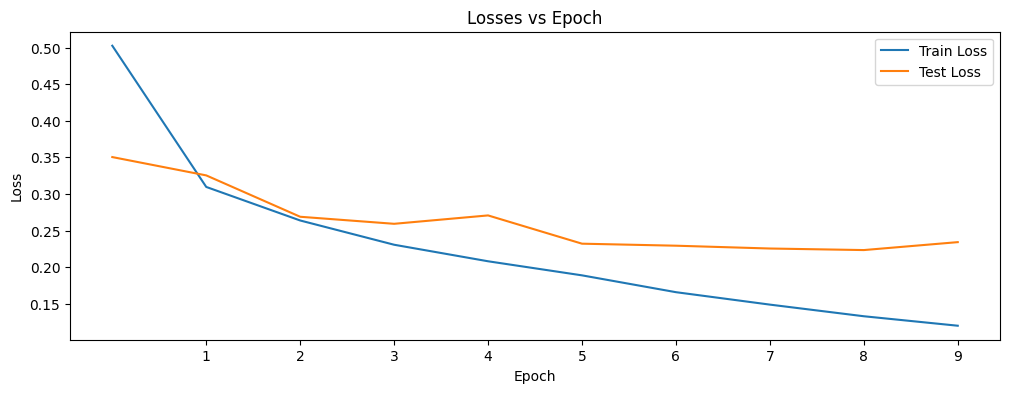

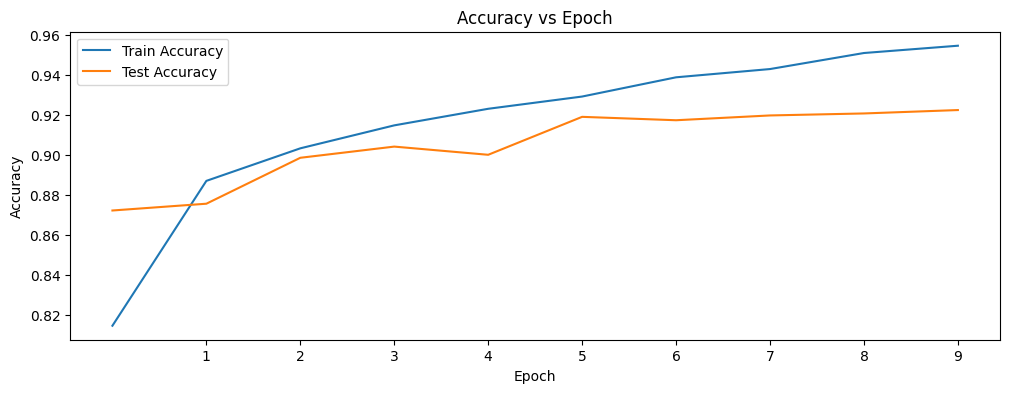

100%|██████████| 40/40 [00:02<00:00, 18.86it/s]


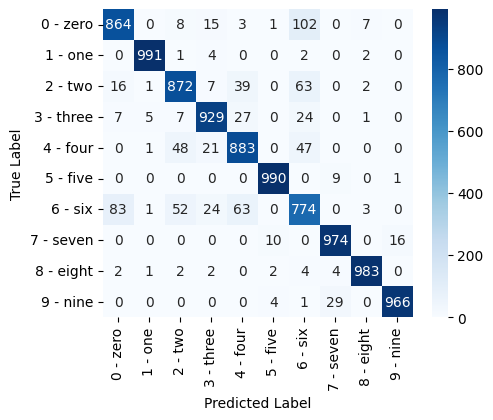

In [57]:
params_5 = get_params_5()
untrained_model = CNN(*params_5)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

## Training on augmented data

In [58]:
learning_rate = 0.001
epochs = 10
train_loader, test_loader = get_datasets(is_cnn=True)

Getting datasets for CNN with data augmentation


100%|██████████| 40/40 [00:01<00:00, 22.89it/s]



Epoch 1, Train Loss: 0.69, Train accuracy: 74.95%, Test accuracy: 83.29%, Test loss: 0.44




100%|██████████| 40/40 [00:02<00:00, 16.48it/s]



Epoch 2, Train Loss: 0.46, Train accuracy: 82.80%, Test accuracy: 87.10%, Test loss: 0.36




100%|██████████| 40/40 [00:01<00:00, 23.72it/s]



Epoch 3, Train Loss: 0.42, Train accuracy: 84.22%, Test accuracy: 87.73%, Test loss: 0.34




100%|██████████| 40/40 [00:01<00:00, 22.99it/s]



Epoch 4, Train Loss: 0.39, Train accuracy: 85.47%, Test accuracy: 88.89%, Test loss: 0.31




100%|██████████| 40/40 [00:01<00:00, 21.05it/s]



Epoch 5, Train Loss: 0.37, Train accuracy: 86.27%, Test accuracy: 89.61%, Test loss: 0.29




100%|██████████| 40/40 [00:01<00:00, 23.77it/s]



Epoch 6, Train Loss: 0.35, Train accuracy: 86.78%, Test accuracy: 89.88%, Test loss: 0.28




100%|██████████| 40/40 [00:01<00:00, 23.78it/s]



Epoch 7, Train Loss: 0.33, Train accuracy: 87.68%, Test accuracy: 90.29%, Test loss: 0.28




100%|██████████| 40/40 [00:01<00:00, 23.60it/s]



Epoch 8, Train Loss: 0.32, Train accuracy: 87.95%, Test accuracy: 90.53%, Test loss: 0.26




100%|██████████| 40/40 [00:02<00:00, 18.86it/s]



Epoch 9, Train Loss: 0.31, Train accuracy: 88.35%, Test accuracy: 90.77%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 24.48it/s]



Epoch 10, Train Loss: 0.30, Train accuracy: 88.72%, Test accuracy: 91.16%, Test loss: 0.25


Training time: 216.15 seconds


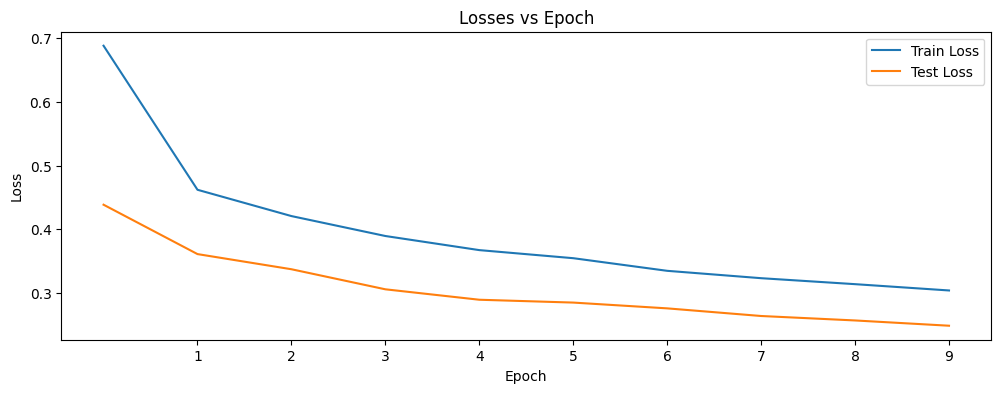

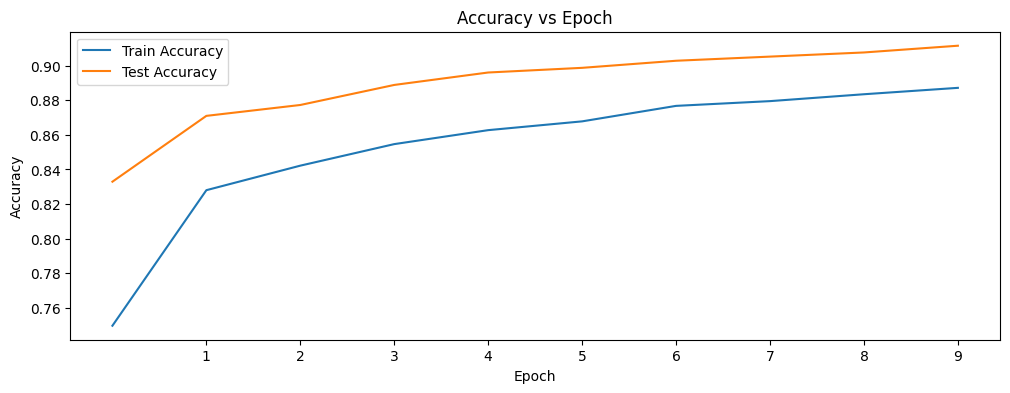

100%|██████████| 40/40 [00:01<00:00, 23.74it/s]


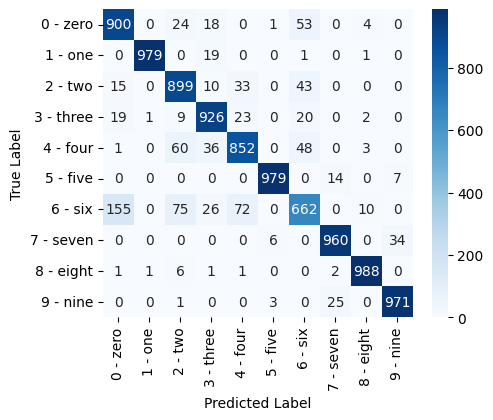

In [59]:
params_1 = get_params_1()
untrained_model = CNN(*params_1)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:01<00:00, 24.64it/s]



Epoch 1, Train Loss: 0.75, Train accuracy: 72.34%, Test accuracy: 82.88%, Test loss: 0.47




100%|██████████| 40/40 [00:02<00:00, 16.70it/s]



Epoch 2, Train Loss: 0.52, Train accuracy: 80.69%, Test accuracy: 85.86%, Test loss: 0.39




100%|██████████| 40/40 [00:01<00:00, 24.74it/s]



Epoch 3, Train Loss: 0.45, Train accuracy: 82.95%, Test accuracy: 86.77%, Test loss: 0.36




100%|██████████| 40/40 [00:01<00:00, 24.48it/s]



Epoch 4, Train Loss: 0.42, Train accuracy: 84.22%, Test accuracy: 87.79%, Test loss: 0.34




100%|██████████| 40/40 [00:01<00:00, 24.81it/s]



Epoch 5, Train Loss: 0.40, Train accuracy: 85.18%, Test accuracy: 88.37%, Test loss: 0.32




100%|██████████| 40/40 [00:01<00:00, 24.39it/s]



Epoch 6, Train Loss: 0.38, Train accuracy: 85.91%, Test accuracy: 88.66%, Test loss: 0.32




100%|██████████| 40/40 [00:02<00:00, 18.54it/s]



Epoch 7, Train Loss: 0.36, Train accuracy: 86.54%, Test accuracy: 89.13%, Test loss: 0.31




100%|██████████| 40/40 [00:01<00:00, 24.13it/s]



Epoch 8, Train Loss: 0.35, Train accuracy: 86.95%, Test accuracy: 89.17%, Test loss: 0.30




100%|██████████| 40/40 [00:01<00:00, 24.29it/s]



Epoch 9, Train Loss: 0.34, Train accuracy: 87.31%, Test accuracy: 89.96%, Test loss: 0.28




100%|██████████| 40/40 [00:01<00:00, 21.76it/s]



Epoch 10, Train Loss: 0.33, Train accuracy: 87.73%, Test accuracy: 90.18%, Test loss: 0.27


Training time: 204.76 seconds


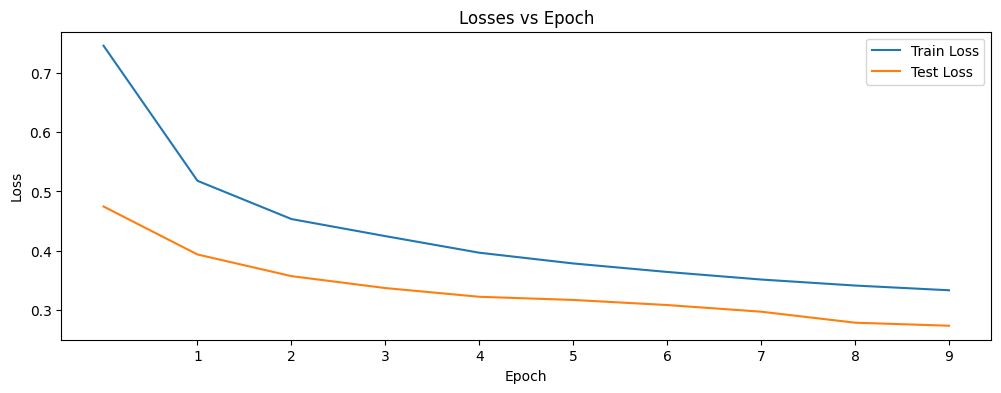

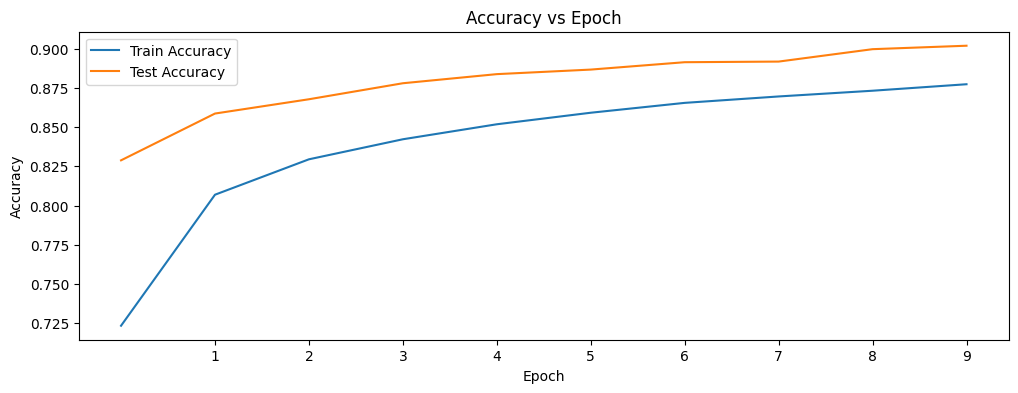

100%|██████████| 40/40 [00:02<00:00, 17.75it/s]


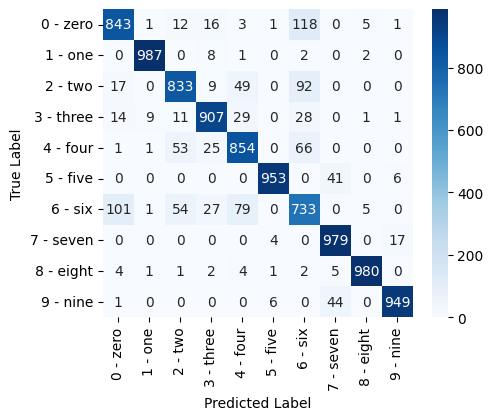

In [60]:
params_2 = get_params_2()
untrained_model = CNN(*params_2)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:01<00:00, 24.47it/s]



Epoch 1, Train Loss: 0.71, Train accuracy: 73.32%, Test accuracy: 82.91%, Test loss: 0.45




100%|██████████| 40/40 [00:01<00:00, 24.13it/s]



Epoch 2, Train Loss: 0.49, Train accuracy: 81.41%, Test accuracy: 85.61%, Test loss: 0.39




100%|██████████| 40/40 [00:02<00:00, 15.62it/s]



Epoch 3, Train Loss: 0.43, Train accuracy: 83.82%, Test accuracy: 87.18%, Test loss: 0.35




100%|██████████| 40/40 [00:01<00:00, 24.50it/s]



Epoch 4, Train Loss: 0.40, Train accuracy: 85.17%, Test accuracy: 88.02%, Test loss: 0.32




100%|██████████| 40/40 [00:01<00:00, 24.07it/s]



Epoch 5, Train Loss: 0.38, Train accuracy: 85.99%, Test accuracy: 88.24%, Test loss: 0.32




100%|██████████| 40/40 [00:02<00:00, 16.10it/s]



Epoch 6, Train Loss: 0.36, Train accuracy: 86.93%, Test accuracy: 89.30%, Test loss: 0.29




100%|██████████| 40/40 [00:01<00:00, 23.71it/s]



Epoch 7, Train Loss: 0.34, Train accuracy: 87.40%, Test accuracy: 89.83%, Test loss: 0.28




100%|██████████| 40/40 [00:01<00:00, 23.41it/s]



Epoch 8, Train Loss: 0.33, Train accuracy: 87.90%, Test accuracy: 90.26%, Test loss: 0.27




100%|██████████| 40/40 [00:02<00:00, 15.61it/s]



Epoch 9, Train Loss: 0.32, Train accuracy: 88.42%, Test accuracy: 90.35%, Test loss: 0.27




100%|██████████| 40/40 [00:01<00:00, 24.19it/s]



Epoch 10, Train Loss: 0.31, Train accuracy: 88.50%, Test accuracy: 90.79%, Test loss: 0.25


Training time: 210.04 seconds


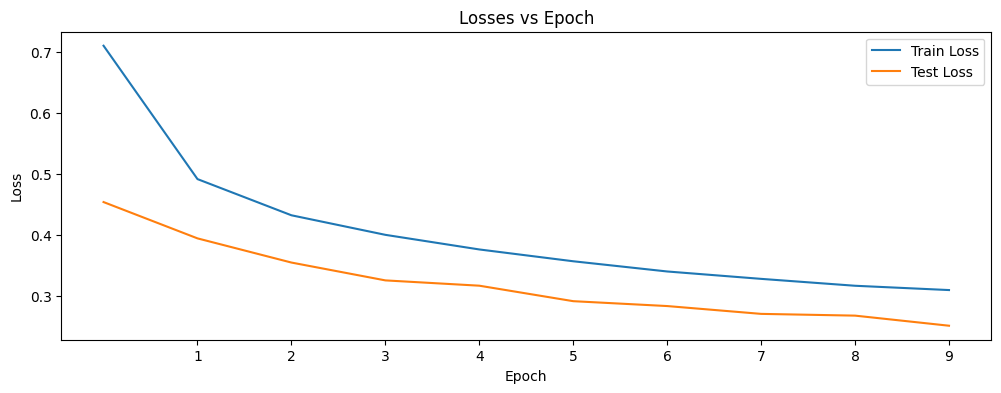

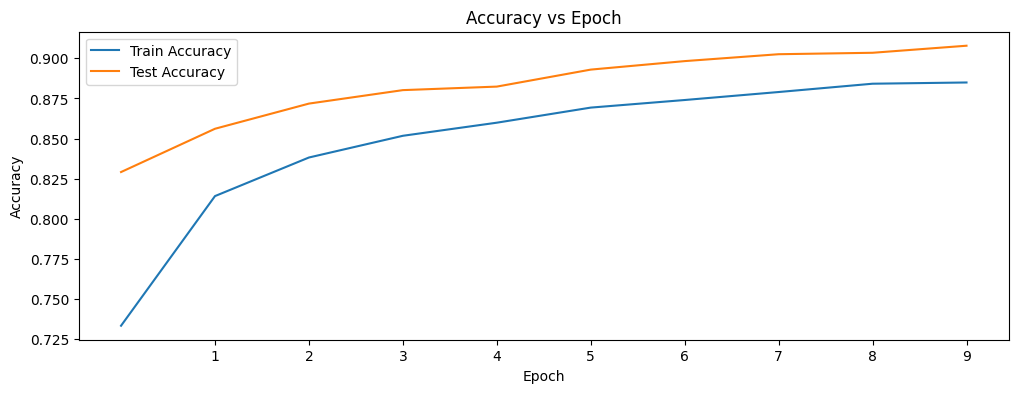

100%|██████████| 40/40 [00:01<00:00, 23.26it/s]


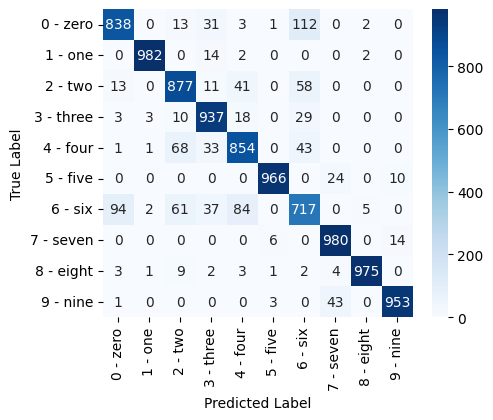

In [61]:
params_3 = get_params_3()
untrained_model = CNN(*params_3)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:01<00:00, 23.58it/s]



Epoch 1, Train Loss: 0.74, Train accuracy: 72.14%, Test accuracy: 82.97%, Test loss: 0.47




100%|██████████| 40/40 [00:02<00:00, 19.36it/s]



Epoch 2, Train Loss: 0.51, Train accuracy: 80.92%, Test accuracy: 83.26%, Test loss: 0.43




100%|██████████| 40/40 [00:01<00:00, 23.88it/s]



Epoch 3, Train Loss: 0.44, Train accuracy: 83.67%, Test accuracy: 86.36%, Test loss: 0.36




100%|██████████| 40/40 [00:01<00:00, 23.74it/s]



Epoch 4, Train Loss: 0.40, Train accuracy: 85.12%, Test accuracy: 88.02%, Test loss: 0.33




100%|██████████| 40/40 [00:02<00:00, 15.80it/s]



Epoch 5, Train Loss: 0.38, Train accuracy: 85.75%, Test accuracy: 88.41%, Test loss: 0.32




100%|██████████| 40/40 [00:01<00:00, 20.71it/s]



Epoch 6, Train Loss: 0.36, Train accuracy: 86.82%, Test accuracy: 88.93%, Test loss: 0.30




100%|██████████| 40/40 [00:01<00:00, 21.59it/s]



Epoch 7, Train Loss: 0.35, Train accuracy: 86.93%, Test accuracy: 89.01%, Test loss: 0.30




100%|██████████| 40/40 [00:02<00:00, 15.89it/s]



Epoch 8, Train Loss: 0.33, Train accuracy: 87.67%, Test accuracy: 89.68%, Test loss: 0.28




100%|██████████| 40/40 [00:01<00:00, 22.80it/s]



Epoch 9, Train Loss: 0.33, Train accuracy: 87.85%, Test accuracy: 90.20%, Test loss: 0.27




100%|██████████| 40/40 [00:01<00:00, 23.20it/s]



Epoch 10, Train Loss: 0.32, Train accuracy: 88.32%, Test accuracy: 90.07%, Test loss: 0.27


Training time: 213.51 seconds


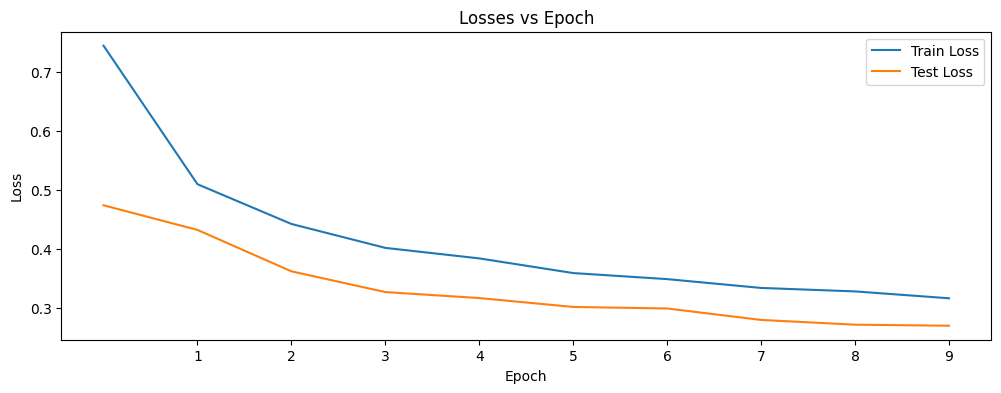

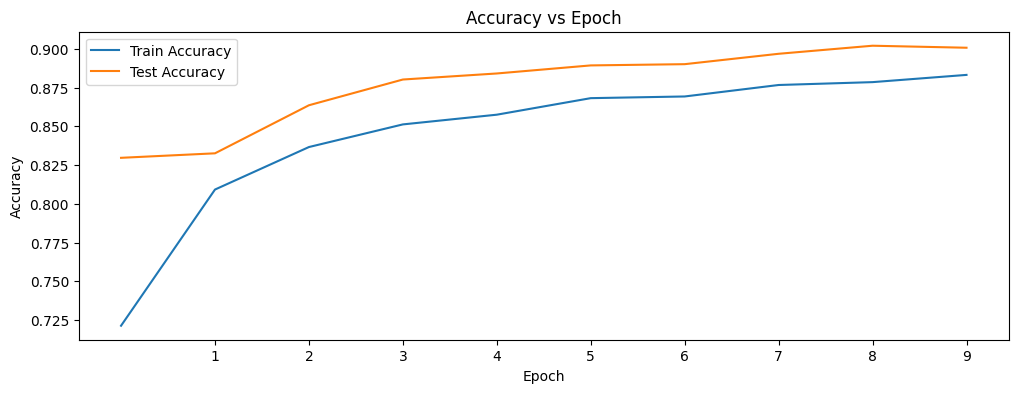

100%|██████████| 40/40 [00:01<00:00, 21.10it/s]


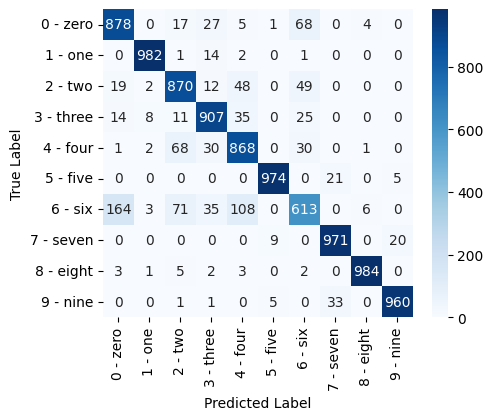

In [62]:
params_4 = get_params_4()
untrained_model = CNN(*params_4)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

100%|██████████| 40/40 [00:01<00:00, 23.01it/s]



Epoch 1, Train Loss: 0.67, Train accuracy: 74.86%, Test accuracy: 84.21%, Test loss: 0.43




100%|██████████| 40/40 [00:02<00:00, 15.49it/s]



Epoch 2, Train Loss: 0.46, Train accuracy: 82.72%, Test accuracy: 86.71%, Test loss: 0.36




100%|██████████| 40/40 [00:01<00:00, 22.45it/s]



Epoch 3, Train Loss: 0.41, Train accuracy: 84.98%, Test accuracy: 86.85%, Test loss: 0.36




100%|██████████| 40/40 [00:01<00:00, 22.91it/s]



Epoch 4, Train Loss: 0.37, Train accuracy: 86.08%, Test accuracy: 88.92%, Test loss: 0.30




100%|██████████| 40/40 [00:02<00:00, 16.47it/s]



Epoch 5, Train Loss: 0.35, Train accuracy: 87.08%, Test accuracy: 89.22%, Test loss: 0.29




100%|██████████| 40/40 [00:01<00:00, 23.32it/s]



Epoch 6, Train Loss: 0.33, Train accuracy: 87.66%, Test accuracy: 89.57%, Test loss: 0.28




100%|██████████| 40/40 [00:01<00:00, 23.22it/s]



Epoch 7, Train Loss: 0.32, Train accuracy: 88.14%, Test accuracy: 90.07%, Test loss: 0.27




100%|██████████| 40/40 [00:01<00:00, 20.52it/s]



Epoch 8, Train Loss: 0.31, Train accuracy: 88.49%, Test accuracy: 90.43%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 23.00it/s]



Epoch 9, Train Loss: 0.30, Train accuracy: 89.00%, Test accuracy: 90.54%, Test loss: 0.26




100%|██████████| 40/40 [00:01<00:00, 23.30it/s]



Epoch 10, Train Loss: 0.29, Train accuracy: 89.21%, Test accuracy: 90.65%, Test loss: 0.26


Training time: 215.95 seconds


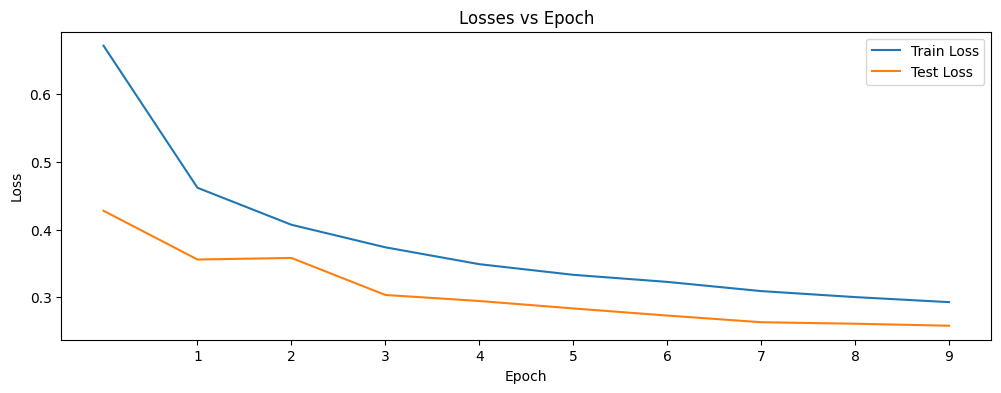

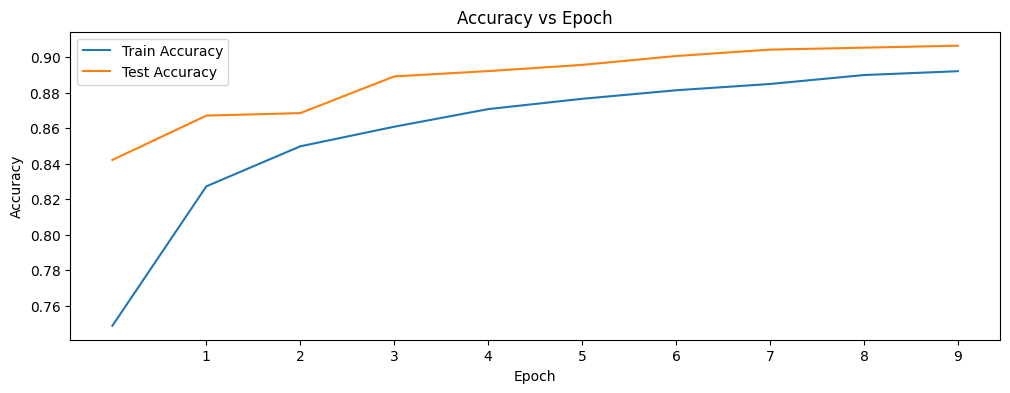

100%|██████████| 40/40 [00:01<00:00, 23.31it/s]


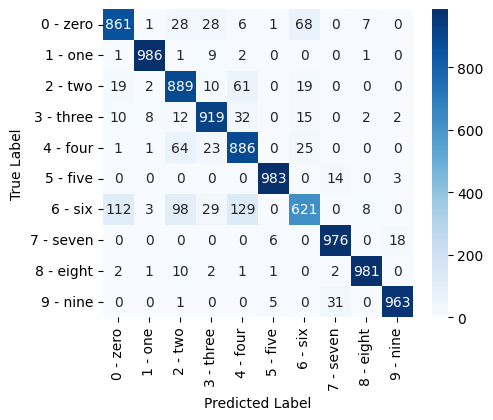

In [63]:
params_5 = get_params_5()
untrained_model = CNN(*params_5)
model = train_model(untrained_model, train_loader, test_loader, epochs, learning_rate)

## ResNet Pretrained Model

In [64]:
def get_params(learning_rate = 0.001):
  weights = ResNet18_Weights.DEFAULT
  resnet = resnet18(weights=weights)
  epochs = 10
  train_loader, test_loader = get_datasets(is_Resnet=True)

  for param in resnet.parameters():
    param.requires_grad = False

  resnet.fc = nn.Sequential(
      nn.Linear(in_features=resnet.fc.in_features, out_features=256),
      nn.ReLU(),
      nn.Dropout(0.25),
      nn.Linear(in_features=256, out_features=10)
  )

  return resnet, epochs, learning_rate, train_loader, test_loader

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 231MB/s]


Getting datasets for ResNet model


100%|██████████| 40/40 [00:03<00:00, 13.13it/s]



Epoch 1, Train Loss: 1.03, Train accuracy: 64.60%, Test accuracy: 72.26%, Test loss: 0.81




100%|██████████| 40/40 [00:02<00:00, 14.19it/s]



Epoch 2, Train Loss: 0.81, Train accuracy: 71.53%, Test accuracy: 72.35%, Test loss: 0.78




100%|██████████| 40/40 [00:03<00:00, 11.02it/s]



Epoch 3, Train Loss: 0.75, Train accuracy: 73.45%, Test accuracy: 73.49%, Test loss: 0.73




100%|██████████| 40/40 [00:02<00:00, 13.89it/s]



Epoch 4, Train Loss: 0.71, Train accuracy: 74.70%, Test accuracy: 74.15%, Test loss: 0.71




100%|██████████| 40/40 [00:02<00:00, 14.36it/s]



Epoch 5, Train Loss: 0.69, Train accuracy: 75.33%, Test accuracy: 74.70%, Test loss: 0.70




100%|██████████| 40/40 [00:03<00:00, 10.38it/s]



Epoch 6, Train Loss: 0.66, Train accuracy: 76.08%, Test accuracy: 75.42%, Test loss: 0.68




100%|██████████| 40/40 [00:02<00:00, 14.09it/s]



Epoch 7, Train Loss: 0.64, Train accuracy: 76.64%, Test accuracy: 75.70%, Test loss: 0.68




100%|██████████| 40/40 [00:02<00:00, 14.02it/s]



Epoch 8, Train Loss: 0.63, Train accuracy: 77.25%, Test accuracy: 76.17%, Test loss: 0.68




100%|██████████| 40/40 [00:03<00:00, 11.13it/s]



Epoch 9, Train Loss: 0.61, Train accuracy: 77.82%, Test accuracy: 75.52%, Test loss: 0.68




100%|██████████| 40/40 [00:02<00:00, 13.71it/s]



Epoch 10, Train Loss: 0.60, Train accuracy: 78.21%, Test accuracy: 76.40%, Test loss: 0.68


Training time: 209.81 seconds


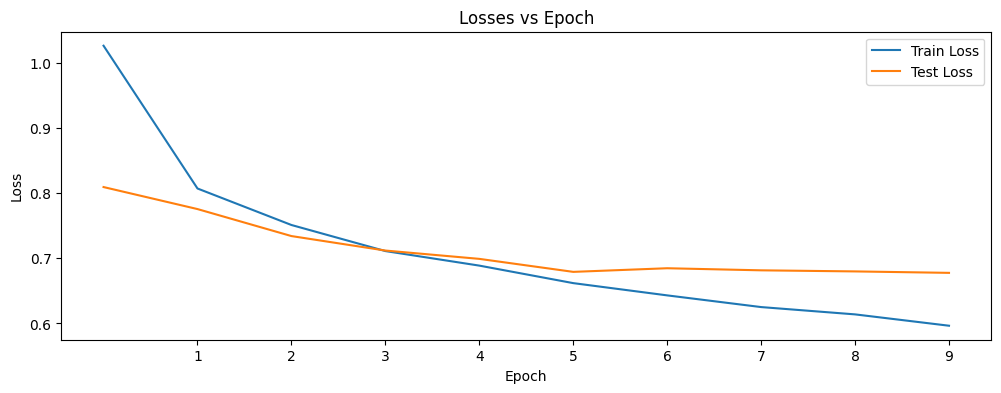

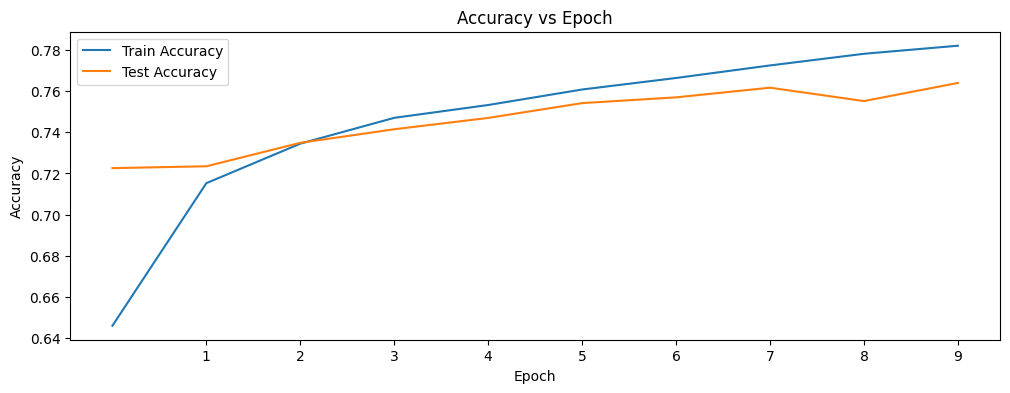

100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


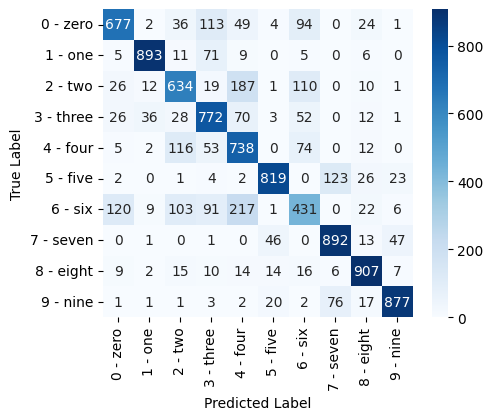

In [65]:
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.001)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)

Getting datasets for ResNet model


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]



Epoch 1, Train Loss: 1.11, Train accuracy: 62.44%, Test accuracy: 70.58%, Test loss: 0.86




100%|██████████| 40/40 [00:02<00:00, 13.81it/s]



Epoch 2, Train Loss: 0.84, Train accuracy: 70.64%, Test accuracy: 72.93%, Test loss: 0.79




100%|██████████| 40/40 [00:02<00:00, 13.71it/s]



Epoch 3, Train Loss: 0.78, Train accuracy: 72.54%, Test accuracy: 73.47%, Test loss: 0.75




100%|██████████| 40/40 [00:03<00:00, 11.58it/s]



Epoch 4, Train Loss: 0.75, Train accuracy: 73.47%, Test accuracy: 74.02%, Test loss: 0.74




100%|██████████| 40/40 [00:02<00:00, 13.72it/s]



Epoch 5, Train Loss: 0.72, Train accuracy: 74.63%, Test accuracy: 74.49%, Test loss: 0.71




100%|██████████| 40/40 [00:02<00:00, 13.90it/s]



Epoch 6, Train Loss: 0.70, Train accuracy: 75.20%, Test accuracy: 74.59%, Test loss: 0.71




100%|██████████| 40/40 [00:04<00:00,  8.99it/s]



Epoch 7, Train Loss: 0.67, Train accuracy: 75.98%, Test accuracy: 75.52%, Test loss: 0.68




100%|██████████| 40/40 [00:03<00:00, 13.30it/s]



Epoch 8, Train Loss: 0.66, Train accuracy: 76.42%, Test accuracy: 75.78%, Test loss: 0.68




100%|██████████| 40/40 [00:02<00:00, 13.70it/s]



Epoch 9, Train Loss: 0.64, Train accuracy: 77.13%, Test accuracy: 76.53%, Test loss: 0.67




100%|██████████| 40/40 [00:03<00:00, 12.34it/s]



Epoch 10, Train Loss: 0.63, Train accuracy: 77.26%, Test accuracy: 76.16%, Test loss: 0.67


Training time: 214.89 seconds


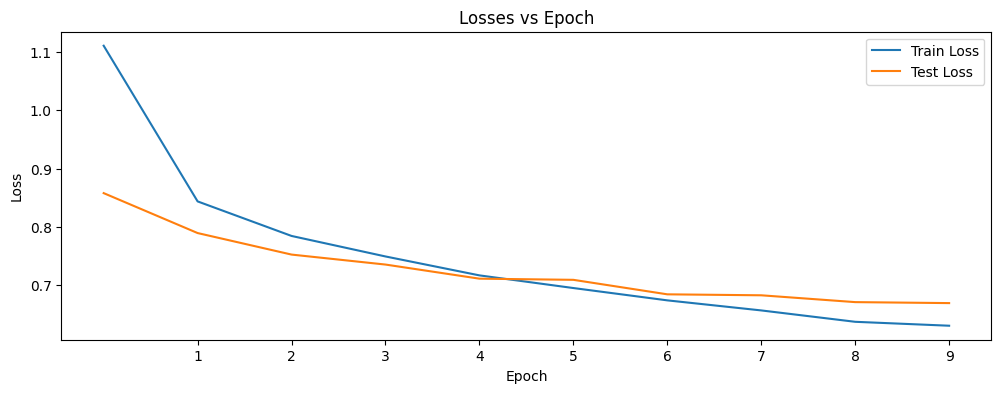

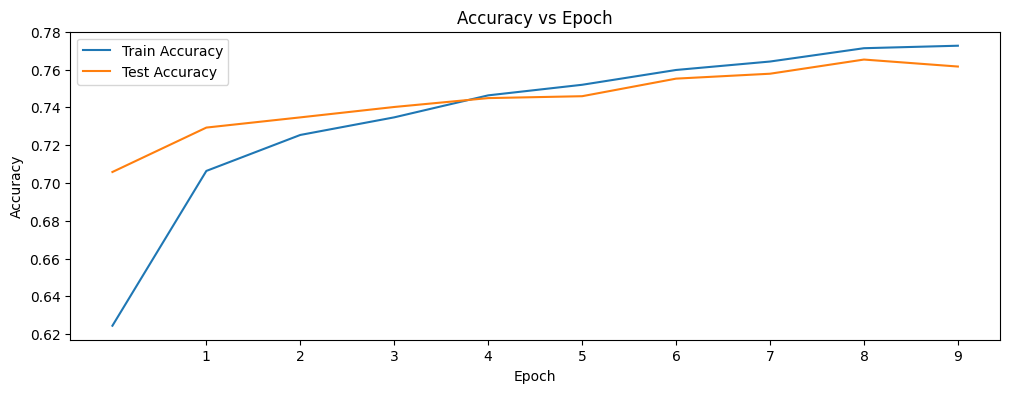

100%|██████████| 40/40 [00:02<00:00, 13.64it/s]


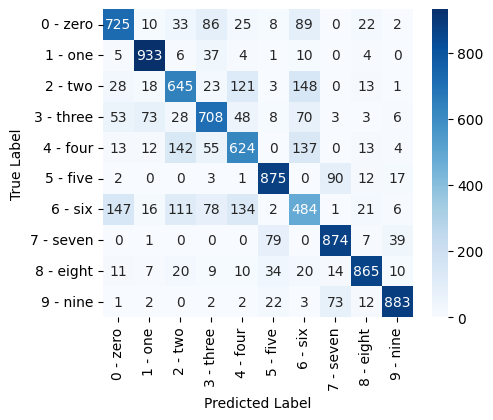

In [66]:
resnet, epochs, learning_rate, train_loader, test_loader = get_params(0.0005)
model = train_model(resnet, train_loader, test_loader, epochs, learning_rate)